# <div align="center"> <font>Multimodal Deep Learning Model for Persuasion Technique Detection</font></div>

# Introduction
### **Introduction**

This project is divided into two main tasks: the primary task focuses on developing a multi-modal deep learning model for classifying persuasive techniques in memes, while the enhancement task extends the capabilities of the model to multi-label sequence tagging for more precise technique identification.

In the **main task**, the model integrates both visual and textual features using advanced architectures. Specifically, DeBERTaV2 is employed for text processing, while ResNet50 and EfficientNetB0 are utilized for image feature extraction. The workflow involves structured data preprocessing, exploratory data analysis (EDA), and feature extraction, followed by the development, training, and evaluation of the multi-modal model. The aim is to accurately classify techniques across multiple categories and ensure the model generalizes well to unseen data.

In the **enhancement task**, the project expands to multi-label sequence tagging. This task focuses on accurately identifying spans of text within the memes that correspond to specific persuasive techniques using advanced sequence labeling methods. The model architecture is adapted using BERT to capture contextual embeddings and predict labels for each token in the text. The goal is to refine the model’s capabilities further, allowing it to classify multiple overlapping techniques within the same meme.

By leveraging state-of-the-art deep learning approaches and integrating multi-modal inputs, the project aims to build a robust and efficient system for identifying and categorizing persuasive techniques in visual and textual content across various scenarios.


### Importing Libraries

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc
from transformers import DebertaV2Tokenizer, TFDebertaV2Model, BertTokenizerFast, TFBertModel

import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, concatenate, Softmax, Layer
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW

import keras_tuner as kt
from keras_cv.losses import FocalLoss
from keras_tuner import RandomSearch


In [2]:
# Automatically tunes performance for data pipelines in TensorFlow
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set style and context for larger labels and a cleaner look
sns.set(style="whitegrid")

# Define a color palette
palette = sns.color_palette("Blues_d")

In [3]:
colab_run = True

if colab_run:
    from google.colab import drive
    drive.mount('/content/drive')
    directory = '/content/drive/My Drive/DL_Assign_2/'

else:
    directory = ''


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# A. Main Task

## 1. Loading Data
In this step, the dataset containing multi-modal data (both text and images) is loaded. The textual data includes meme captions and associated labels, while the image data corresponds to visual elements in the memes. The data is read into structured formats like Pandas DataFrames to facilitate subsequent preprocessing and analysis steps. This foundational step ensures that all required data is accessible for further processing and model training.

In [4]:
def load_data_from_file(folder_name, filename):
    """
    Loads a JSON-like dataset from a specified text file in a folder and returns it as a Pandas DataFrame.

    Args:
    folder_name (str): The name of the folder containing the file.
    filename (str): The name of the text file.

    Returns:
    pd.DataFrame: A DataFrame with the loaded data.
    """
    try:
        # Create the full path to the file
        full_path = f"{folder_name}/{filename}"

        # Open and read the content of the file
        with open(full_path, 'r') as file:
            data = file.read()

        # Parse the JSON content
        data = json.loads(data)

        # Convert the parsed data into a Pandas DataFrame
        df = pd.DataFrame(data)

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


### 1.1 Loading Training Data

In [5]:
# Define the folder and file names for the training dataset
train_folder_name = f'{directory}MainTask/training_set_task3'
train_filename = 'training_set_task3.txt'

# Load the training data into a DataFrame
train_df = load_data_from_file(train_folder_name, train_filename)


In [6]:
# Update the 'image' column to contain the full paths
train_df['image'] = train_df['image'].apply(lambda x: os.path.join(train_folder_name, x))

### 1.2 Loading Validation Data

In [7]:
# Define the folder and file names for the development dataset
dev_folder_name = f'{directory}MainTask/dev_set_task3_labeled'
dev_filename = 'dev_set_task3_labeled.txt'

# Load the development data into a DataFrame
dev_df = load_data_from_file(dev_folder_name, dev_filename)


In [8]:
# Update the 'image' column to contain the full paths
dev_df['image'] = dev_df['image'].apply(lambda x: os.path.join(dev_folder_name, x))

### 1.3 Loading Testing Data

In [9]:
# Define the folder and file names for the test dataset
test_folder_name = f'{directory}MainTask/test_set_task3'
test_filename = 'test_set_task3.txt'

# Load the test data into a DataFrame
test_df = load_data_from_file(test_folder_name, test_filename)


In [10]:
# Update the 'image' column to contain the full paths
test_df['image'] = test_df['image'].apply(lambda x: os.path.join(test_folder_name, x))

### 1.4 Load the possible techniques

In [11]:
# Define the file path
file_path = f'{directory}MainTask/techniques_list_task3.txt'

try:
    # Open and read the file, filtering out empty lines
    with open(file_path, 'r') as file:
        techniques_list = [line.strip() for line in file if line.strip()]

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path and try again.")



## 2. EDA
EDA is conducted to gain a deeper understanding of the dataset and identify any potential issues that may need addressing before model development. By exploring the data, we can visualize label distributions, check for inconsistencies, and identify patterns that inform subsequent preprocessing and modeling strategies.

### 2.1 Data Sample
A quick inspection of a few samples from the dataset helps verify the data structure and contents. This initial exploration confirms that the text and image columns, along with the associated labels, are in the expected format, providing a clear snapshot of the dataset.

In [12]:
train_df.head()

,id,labels,text,image
0,128,"[Black-and-white Fallacy/Dictatorship, Name ca...",THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n,/content/drive/My Drive/DL_Assign_2/MainTask/t...
1,189,"[Reductio ad hitlerum, Smears, Transfer]",This is not an accident!,/content/drive/My Drive/DL_Assign_2/MainTask/t...
2,96,"[Appeal to fear/prejudice, Loaded Language, Na...",SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,/content/drive/My Drive/DL_Assign_2/MainTask/t...
3,154,"[Causal Oversimplification, Glittering general...",PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...,/content/drive/My Drive/DL_Assign_2/MainTask/t...
4,15,"[Flag-waving, Misrepresentation of Someone's P...",WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n,/content/drive/My Drive/DL_Assign_2/MainTask/t...


In [13]:
dev_df.head()

,id,labels,text,image
0,62_batch_2,"[Smears, Doubt]","*President* Biden?\n\nPlease, no.\n",/content/drive/My Drive/DL_Assign_2/MainTask/d...
1,111_batch_2,"[Smears, Loaded Language, Name calling/Labeling]","JOE VERSUS THE VOLCANIC KREMLIN DON\n\n""WILL ...",/content/drive/My Drive/DL_Assign_2/MainTask/d...
2,167_batch_2,"[Smears, Transfer]",ANTI-VAXXERS BE LIKE... \n\nHANG ON A SEC - JU...,/content/drive/My Drive/DL_Assign_2/MainTask/d...
3,93_batch_2,[],VIRUS BINGO\nFREE 32 SPACE\n,/content/drive/My Drive/DL_Assign_2/MainTask/d...
4,153_batch_2,"[Smears, Exaggeration/Minimisation, Loaded Lan...",Never thought l'd die fighting IRRESPONSIBLY R...,/content/drive/My Drive/DL_Assign_2/MainTask/d...


In [14]:
test_df.head()

,id,labels,text,image
0,705_batch_2,"[Name calling/Labeling, Slogans, Smears, Trans...",The Democrats New America\n,/content/drive/My Drive/DL_Assign_2/MainTask/t...
1,706_batch_2,"[Appeal to (Strong) Emotions, Appeal to fear/p...",WE ARE AT WAR!\n\nThere is a complex assault o...,/content/drive/My Drive/DL_Assign_2/MainTask/t...
2,710_batch_2,"[Doubt, Loaded Language, Name calling/Labeling]",KILLED HIMSELF IN PRISON\n\nWON AN HONEST ELEC...,/content/drive/My Drive/DL_Assign_2/MainTask/t...
3,713_batch_2,"[Exaggeration/Minimisation, Loaded Language]",I will never concede!\n\nNO WAY IN HELL BIDEN ...,/content/drive/My Drive/DL_Assign_2/MainTask/t...
4,715_batch_2,[Doubt],TRYING TO FIGURE OUT HOW BIDEN WON A RECORD LO...,/content/drive/My Drive/DL_Assign_2/MainTask/t...


In [15]:
for i , technique in enumerate(techniques_list):
    print(f"{i+1} : {technique}")

num_labels = len(techniques_list)
print(f"Total number of technique: {num_labels}")

1 : Appeal to authority
2 : Appeal to fear/prejudice
3 : Black-and-white Fallacy/Dictatorship
4 : Causal Oversimplification
5 : Doubt
6 : Exaggeration/Minimisation
7 : Flag-waving
8 : Glittering generalities (Virtue)
9 : Loaded Language
10 : Misrepresentation of Someone's Position (Straw Man)
11 : Name calling/Labeling
12 : Obfuscation, Intentional vagueness, Confusion
13 : Presenting Irrelevant Data (Red Herring)
14 : Reductio ad hitlerum
15 : Repetition
16 : Slogans
17 : Smears
18 : Thought-terminating cliché
19 : Whataboutism
20 : Bandwagon
21 : Transfer
22 : Appeal to (Strong) Emotions
Total number of technique: 22


In [16]:
def show_image_with_labels(image_path, text, labels):
    """
    Displays an image along with its corresponding labels in the title.

    Args:
    image_path (str): The full path to the image file.
    text (str): The text associated with the image.
    labels (list): A list of labels related to the image.
    """
    # Load the image
    img = Image.open(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide the axis

    # Set the title to include the text and labels
    plt.title(f"Text: {text}\nLabels: {', '.join(labels)}", fontsize=10)
    plt.show()


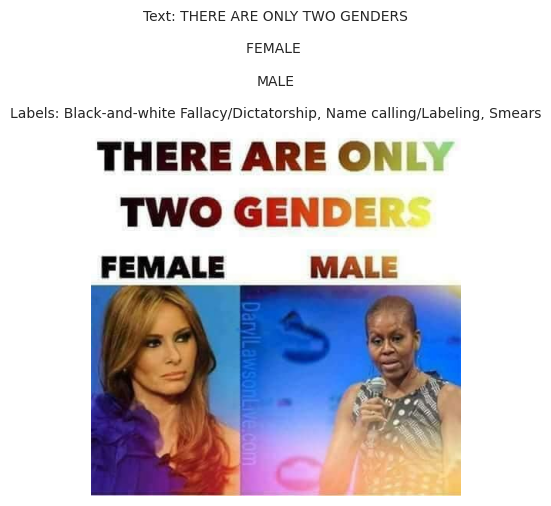

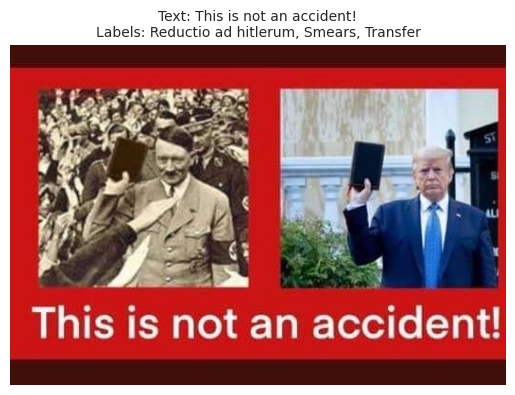

In [17]:
# Function to display multiple images along with their corresponding labels
def show_multiple_images_with_labels(df, num_images=5):
    """
    Displays a specified number of images with their associated labels.

    Args:
    df (pd.DataFrame): DataFrame containing 'image', 'text', and 'labels' columns.
    num_images (int): The number of images to display.
    """
    # Retrieve image details
    for i in range(num_images):
        image_path = df.iloc[i]['image']
        text = df.iloc[i]['text']
        labels = df.iloc[i]['labels']

        # Show the image with its corresponding labels
        show_image_with_labels(image_path, text, labels)

# Display the first two images from the training DataFrame
show_multiple_images_with_labels(train_df, num_images=2)


### 2.2 Rows with Missing labels
This analysis identifies any instances where labels are missing or incomplete. Detecting these anomalies early is crucial, as missing labels could lead to biased training or evaluation. If such instances are found, they may be removed or handled appropriately to maintain data quality.

In [18]:
# Identify rows in train_df with empty labels
empty_list_rows_train = train_df[train_df['labels'].apply(lambda x: len(x) == 0)]
print(f"Rows with empty labels in train: {empty_list_rows_train['labels'].count()}")

# Identify rows in dev_df with empty labels
empty_list_rows_dev = dev_df[dev_df['labels'].apply(lambda x: len(x) == 0)]
print(f"Rows with empty labels in dev: {empty_list_rows_dev['labels'].count()}")

# Identify rows in test_df with empty labels
empty_list_rows_test = test_df[test_df['labels'].apply(lambda x: len(x) == 0)]
print(f"Rows with empty labels in test: {empty_list_rows_test['labels'].count()}")


Rows with empty labels in train: 29
Rows with empty labels in dev: 3
Rows with empty labels in test: 4


In the dataset, there are 29 rows with empty labels in the training set, 3 in the development set, and 4 in the test set. These rows may not need handling due to very less count to maintain data quality during training and evaluation.

### 2.3 Label Distribution
Understanding the distribution of labels across the dataset is important for recognizing potential class imbalances. By plotting the frequency of each label, we can identify underrepresented classes that may need techniques like oversampling or weighted loss functions during model training.

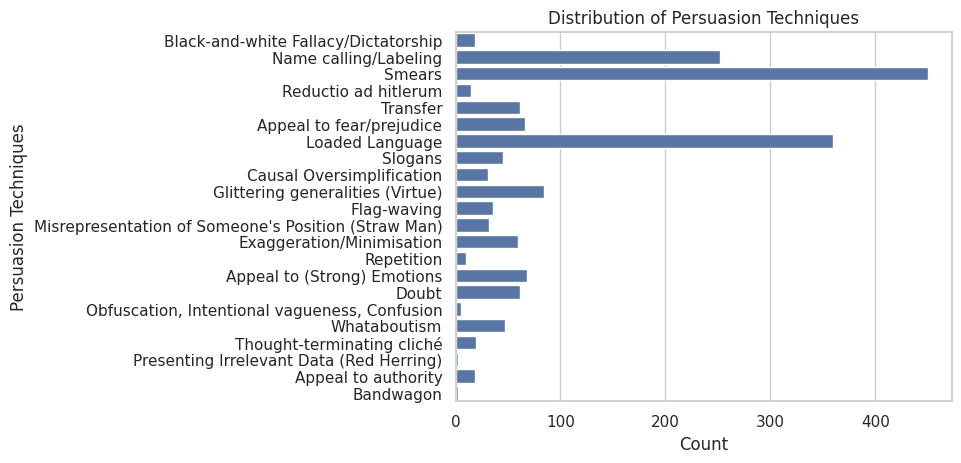

In [19]:
# Flatten the list of labels and count the occurrences of each label
label_counts = Counter([label for sublist in train_df['labels'] for label in sublist])

# Convert the label counts into a DataFrame for easier visualization
label_counts_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])

# Plot the distribution of persuasion techniques
sns.barplot(x=label_counts_df['Count'], y=label_counts_df.index)
plt.title("Distribution of Persuasion Techniques")
plt.xlabel("Count")
plt.ylabel("Persuasion Techniques")
plt.show()

### 2.4 Text Length Distribution
This analysis examines the length of text data within the dataset, such as meme captions. Plotting the distribution of text lengths helps in determining appropriate padding or truncation lengths, ensuring consistency when tokenizing and processing textual data.

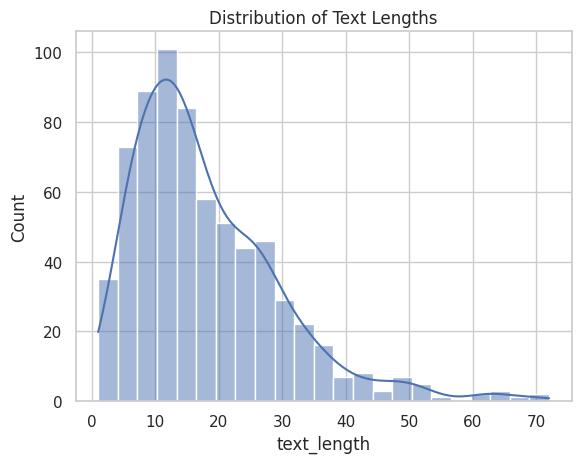

count    687.000000
mean      17.982533
std       11.568770
min        1.000000
25%       10.000000
50%       15.000000
75%       24.000000
max       72.000000
Name: text_length, dtype: float64


In [20]:
temp_df = pd.DataFrame()

# Calculate the length of text for each sample in words
temp_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths with a kernel density estimate
sns.histplot(temp_df['text_length'], kde=True)
plt.title("Distribution of Text Lengths")
plt.show()

# Display descriptive statistics for text lengths to check for outliers
print(temp_df['text_length'].describe())


The text length statistics show an average of approximately 18 words per text with a standard deviation of around 11.5. The minimum length is 1 word, and the maximum is 72 words, indicating a wide range of text lengths that may require truncation or padding.

### 2.5 Multi-Label Frequency
In multi-label classification, it’s essential to understand the frequency of samples with multiple labels. This analysis provides insight into how common multi-label instances are, informing the model design and training approach, such as using specific metrics or loss functions suited for multi-label scenarios.

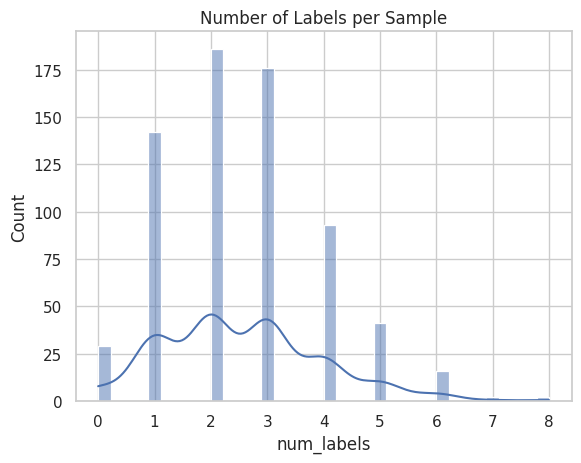

In [21]:
# Count the number of labels for each sample
temp_df['num_labels'] = train_df['labels'].apply(len)

# Plot the distribution of the number of labels per sample with a kernel density estimate
sns.histplot(temp_df['num_labels'], kde=True)
plt.title("Number of Labels per Sample")
plt.show()

### 2.6 Image Distribution
By inspecting the distribution of image data, we ensure the dataset contains a balanced variety of visual content. This step helps confirm the diversity of image types and characteristics, which is important for training a model that generalizes well.

Number of negative samples: 29
Number of positive samples: 658


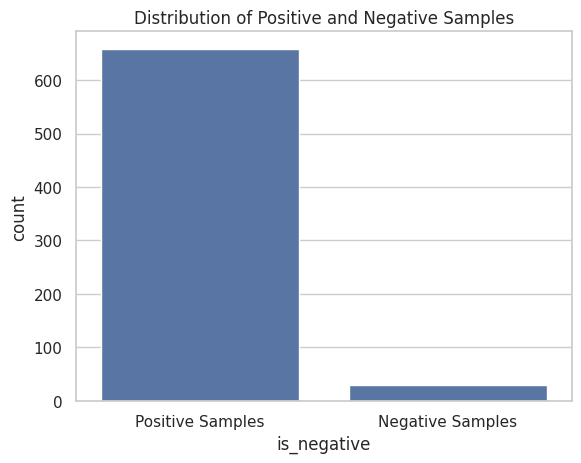

In [22]:
# Function to determine if a sample is negative (i.e., has no labels)
def is_negative_sample(row):
    return len(row['labels']) == 0  # A sample is negative if there are no labels

# Apply the function to the DataFrame to create a new column indicating negative samples
temp_df['is_negative'] = train_df.apply(is_negative_sample, axis=1)

# Count the total number of negative samples
num_negative_samples = temp_df['is_negative'].sum()

# Count the total number of positive samples
num_positive_samples = len(train_df) - num_negative_samples

print(f"Number of negative samples: {num_negative_samples}")
print(f"Number of positive samples: {num_positive_samples}")

# Plot the distribution of positive and negative samples
sns.countplot(x='is_negative', data=temp_df)
plt.xticks([0, 1], ['Positive Samples', 'Negative Samples'])
plt.title("Distribution of Positive and Negative Samples")
plt.show()


The dataset contains 29 negative samples (no labels) and 658 positive samples (with labels). This suggests a relatively small portion of the dataset lacks labels, which may influence data handling and balancing techniques.

### 2.7 Image Size
Analyzing the dimensions of images in the dataset helps in determining the preprocessing steps needed, such as resizing. This ensures that all images are of a consistent size suitable for feeding into the CNN-based feature extraction models, maintaining uniformity and enhancing model performance.

In [23]:
# Function to retrieve the dimensions of an image
def get_image_size(image_path):
    img = Image.open(image_path)
    return img.size  # Returns a tuple (width, height)

# Lists to store the widths and heights of the images
widths = []
heights = []

# Iterate through the images in the DataFrame and collect their dimensions
for img_name in train_df['image']:  # Get each image name from the DataFrame
    width, height = get_image_size(img_name)  # Get the size of the image
    widths.append(width)  # Store the width
    heights.append(height)  # Store the height


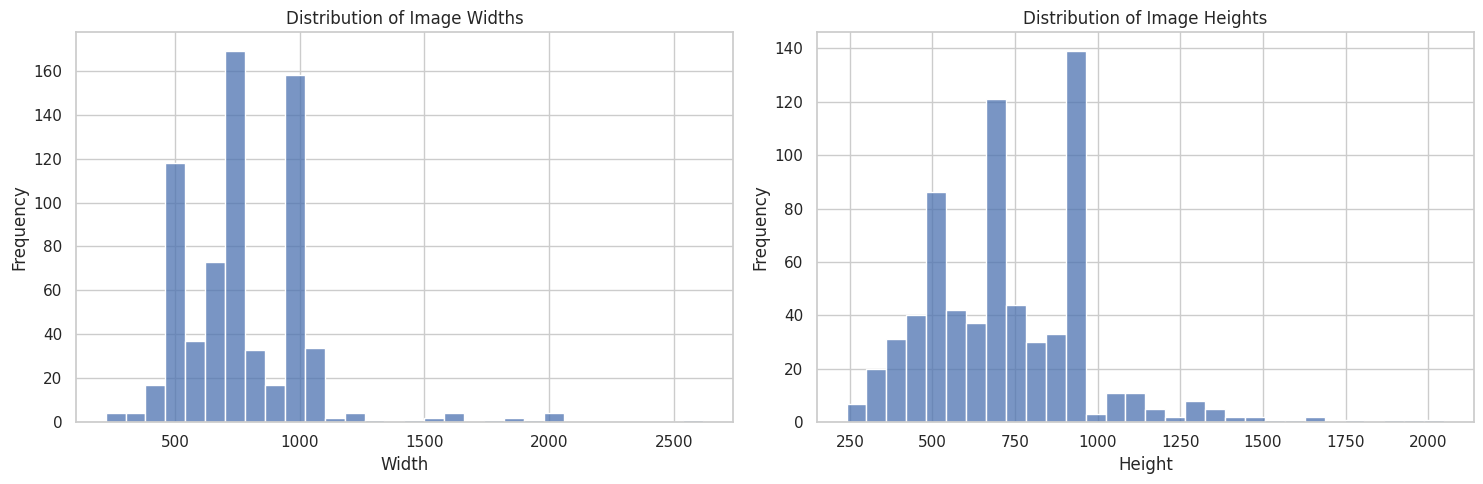

In [24]:
# Create subplots for the distribution of image widths and heights
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram for the distribution of image widths
sns.histplot(widths, kde=False, bins=30, ax=axes[0])  # Plot on the first subplot
axes[0].set_title('Distribution of Image Widths')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Frequency')

# Histogram for the distribution of image heights
sns.histplot(heights, kde=False, bins=30, ax=axes[1])  # Plot on the second subplot
axes[1].set_title('Distribution of Image Heights')
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## 3. Preprocessing

### 3.1 One Hot Encoding
The MultiLabelBinarizer is used to transform the labels into one-hot encoded vectors. This step converts the multi-label format into a numerical form suitable for model training, enabling the model to learn associations between each class and the features effectively. The one-hot encoded labels are then added back to the respective dataframes for training, development, and test sets.

In [25]:
# Initialize the MultiLabelBinarizer with the loaded techniques
mlb = MultiLabelBinarizer(classes=techniques_list)

# Fit and transform the 'labels' column (which contains lists of techniques)
train_labels_one_hot = mlb.fit_transform(train_df['labels'])

# Add the encoded labels back into the dataframe as a new column
train_df['encoded_labels'] = list(train_labels_one_hot)

# Fit and transform the 'labels' column (which contains lists of techniques)
dev_labels_one_hot = mlb.fit_transform(dev_df['labels'])

# Add the encoded labels back into the dataframe as a new column
dev_df['encoded_labels'] = list(dev_labels_one_hot)

# Fit and transform the 'labels' column (which contains lists of techniques)
test_labels_one_hot = mlb.fit_transform(test_df['labels'])

# Add the encoded labels back into the dataframe as a new column
test_df['encoded_labels'] = list(test_labels_one_hot)

num_classes = len(mlb.classes_)

### 3.2 Text Pre-Processing and Feature Extraction

**DeBERTa Tokenization and Embedding Extraction**

In this section, the DeBERTaV2 tokenizer and model are employed to effectively process text data and extract meaningful features. The process consists of several key steps:

1. **Tokenization and Encoding:**
   The DeBERTaV2 tokenizer converts raw text into tokens, which are numerical representations that can be fed into the model. The `encode_plus` method is utilized to prepare the text for the DeBERTa model, which includes:
   - Adding special tokens such as `[CLS]` (indicating the start of the sequence) and `[SEP]` (indicating the end of the sequence).
   - Padding the sequences to a fixed maximum length (128 tokens) to ensure uniformity in input size across the dataset.
   - Truncating longer sequences to fit within the maximum length constraint, preventing errors during model training.
   - Returning the processed input as TensorFlow tensors, which are compatible with the model's requirements.

2. **Feature Extraction:**
   After tokenization, the encoded input is passed to the DeBERTa model, which generates embeddings from the last hidden state. The embeddings capture the semantic content of the text, reflecting the meaning and context of words and phrases within the sentences. To obtain a single representation for each input text, the mean of the last hidden state is computed across all tokens, resulting in a pooled output that condenses the information.

3. **Normalization:**
   To enhance the model's performance, the pooled embeddings are normalized using L2 normalization. This step ensures that all feature vectors have a consistent scale, preventing any single feature from disproportionately influencing the model's predictions. L2 normalization scales the output to unit length, which is particularly beneficial in high-dimensional spaces.

4. **Feature Integration:**
   The normalized embeddings are then incorporated back into the dataset as a new column labeled ‘text_features.’ This transformation into dense vector representations allows the model to leverage complex language patterns and relationships, which are crucial for accurate classification tasks, particularly in a multi-label context.

**Application to Datasets:**
The processing function is subsequently applied to the training, validation, and test datasets (`train_df`, `dev_df`, and `test_df`) to extract the text features. This ensures that all datasets are equipped with the necessary embeddings to feed into the multi-modal classification model.

In [26]:
# Initialize DeBERTa tokenizer and model
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
deberta_model = TFDebertaV2Model.from_pretrained('microsoft/deberta-v3-base')

# Function to prepare text for DeBERTa and return embeddings
def extract_text_features(text, max_length=128):
    # Tokenize and encode text for DeBERTa
    encoded_input = tokenizer.encode_plus(
        text,                          # Input text
        add_special_tokens=True,       # Add [CLS] and [SEP] tokens
        max_length=max_length,         # Maximum sequence length
        padding='max_length',          # Pad sequences to max length
        truncation=True,               # Truncate sequences to max length
        return_tensors='tf'            # Return TensorFlow tensors
    )

    # Extract the DeBERTa embeddings
    deberta_output = deberta_model(encoded_input['input_ids'], attention_mask=encoded_input['attention_mask'])
    pooled_output = tf.reduce_mean(deberta_output.last_hidden_state, axis=1)

    # Normalize the features using L2 normalization
    normalized_pooled_output = tf.nn.l2_normalize(pooled_output, axis=-1)

    return normalized_pooled_output

def process_text_for_deberta(df, text_column):
    deberta_features_list = []

    for text in df[text_column]:
        # Extract DeBERTa features
        text_features = extract_text_features(text)

        # Remove the extra batch dimension
        text_features = tf.squeeze(text_features, axis=0)

        # Append the features to the list
        deberta_features_list.append(text_features)

    df['text_features'] = deberta_features_list

    return df

# Apply the processing function to extract text features for the training dataset
train_df = process_text_for_deberta(train_df, 'text')

# Apply the processing function to extract text features for the validation dataset
dev_df = process_text_for_deberta(dev_df, 'text')

# Apply the processing function to extract text features for the test dataset
test_df = process_text_for_deberta(test_df, 'text')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers o

### 3.3 Image Pre-Processing and Feature Extraction

**Image Loading and Resizing**

This section starts by standardizing the dimensions of input images to (224, 224) pixels. This uniformity is essential for compatibility with pre-trained models, which expect a specific input size. Resizing ensures that all images maintain a consistent format, reducing potential errors during the feature extraction process.

**ResNet50 and EfficientNetB0 Feature Extraction**

Two pre-trained models, ResNet50 and EfficientNetB0, are leveraged to extract visual features from the images. Both models are loaded without their classification layers (i.e., `include_top=False`), which allows us to access the feature representations learned during their training on the ImageNet dataset. The extracted features are pooled using average pooling (`pooling='avg'`), resulting in a compact representation of each image.

**Normalization:**
After feature extraction, the features from both models are normalized using L2 normalization. This step scales the features to have a unit length, ensuring uniformity in feature representation, which is crucial for subsequent model training. Normalization helps mitigate the effects of varying scales across different feature sets, enhancing model performance.

**Batch Processing:**

Images are processed in batches to optimize memory usage and computational efficiency. The `batch_image_feature_extraction` function handles this batch processing:
- It iterates over the list of image paths, preprocessing each image by resizing and converting it to an array format suitable for model input.
- The images are then converted into TensorFlow tensors for compatibility with the models.
- The feature extraction from both ResNet50 and EfficientNetB0 is performed in parallel for each batch, and the resulting features are normalized.

The normalized features from both models are concatenated to form a combined feature representation. This dual-model approach captures different aspects of visual patterns, allowing the model to understand image content and context more comprehensively.

**Feature Integration:**
Finally, the combined normalized features are stored back into the respective DataFrames (`train_df`, `dev_df`, and `test_df`) under the column ‘image_features.’ This integration ensures that the extracted visual features are available for training and evaluation in the multimodal classification task.


The entire pipeline effectively prepares and extracts image features, ensuring that the multimodal model has access to high-quality visual representations, which are crucial for improving classification performance.


In [27]:
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Preprocess a single image for input into a model.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

In [28]:
# Load the pre-trained ResNet50 and EfficientNetB0 model, excluding the top classification layer
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')


# Batch feature extraction function that returns a TensorFlow tensor
def batch_image_feature_extraction(image_paths, batch_size=32):
    combined_features_list = []

    # Loop through the image paths and preprocess them in batches
    for start_idx in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[start_idx:start_idx + batch_size]

        # Preprocess all images in the current batch for ResNet50
        batch_images_resnet = np.vstack([preprocess_resnet(preprocess_image(img_path, (224, 224))) for img_path in batch_paths])
        batch_images_resnet = tf.convert_to_tensor(batch_images_resnet)

        # Preprocess all images in the current batch for EfficientNetB0
        batch_images_efficientnet = np.vstack([preprocess_efficientnet(preprocess_image(img_path, (224, 224))) for img_path in batch_paths])
        batch_images_efficientnet = tf.convert_to_tensor(batch_images_efficientnet)

        # Extract features using the pre-trained models
        resnet_features = resnet_model(batch_images_resnet)
        efficientnet_features = efficientnet_model(batch_images_efficientnet)

        # Normalize the extracted features using L2 normalization
        resnet_normalized = tf.nn.l2_normalize(resnet_features, axis=-1)
        efficientnet_normalized = tf.nn.l2_normalize(efficientnet_features, axis=-1)

        # Concatenate the normalized features
        combined_features = tf.concat([resnet_normalized, efficientnet_normalized], axis=-1)

        # Append normalized features (convert to a list of tensors for concatenation later)
        combined_features_list.append(combined_features)

    # Concatenate all the batches of features into a single TensorFlow tensor
    return tf.concat(combined_features_list, axis=0)


In [29]:
# Extract features for the entire dataset in batches and store as TensorFlow tensor
trin_image_paths = train_df['image'].tolist()
train_image_features = batch_image_feature_extraction(trin_image_paths, batch_size=32)

# Save the image features as TensorFlow tensors in the DataFrame
train_df['image_features'] = list(train_image_features)


# Extract features for the entire dataset in batches and store as TensorFlow tensor
dev_image_paths = dev_df['image'].tolist()
dev_image_features = batch_image_feature_extraction(dev_image_paths, batch_size=32)

# Save the image features as TensorFlow tensors in the DataFrame
dev_df['image_features'] = list(dev_image_features)

# Extract features for the entire dataset in batches and store as TensorFlow tensor
test_image_paths = test_df['image'].tolist()
test_image_features = batch_image_feature_extraction(test_image_paths, batch_size=32)

# Save the image features as TensorFlow tensors in the DataFrame
test_df['image_features'] = list(test_image_features)


## 4. Dataset

This section prepares the training, validation, and test datasets for a multimodal deep learning model. It stacks the text and image features from the respective dataframes into TensorFlow tensors. The one-hot encoded labels are converted into NumPy arrays and subsequently into TensorFlow tensors for training, validation, and testing.

- **Training Data:**
  - Text features are stacked into `X_train_text`, and image features into `X_train_image`.
  - Labels are converted to TensorFlow tensors as `y_train`.

- **Validation Data:**
  - Similar processing is applied to validation datasets, resulting in `X_val_text`, `X_val_image`, and `y_val`.

- **Test Data:**
  - Test datasets are processed similarly, resulting in `X_test_text`, `X_test_image`, and `y_test`.


In [30]:
# Prepare the training data
X_train_text = tf.stack(train_df['text_features'].values)
X_train_image = tf.stack(train_df['image_features'].values)

# Convert the one-hot encoded labels into TensorFlow tensors for training
y_train_np = np.array(train_df['encoded_labels'].values.tolist(), dtype=np.float32)
y_train = tf.convert_to_tensor(y_train_np, dtype=tf.float32)


# Prepare the validation data
X_val_text = tf.stack(dev_df['text_features'].values)
X_val_image = tf.stack(dev_df['image_features'].values)

# Convert the one-hot encoded labels into TensorFlow tensors for validation
y_val_np = np.array(dev_df['encoded_labels'].values.tolist(), dtype=np.float32)
y_val = tf.convert_to_tensor(y_val_np, dtype=tf.float32)

# Prepare the validation data
X_test_text = tf.stack(test_df['text_features'].values)
X_test_image = tf.stack(test_df['image_features'].values)

# Convert the one-hot encoded labels into TensorFlow tensors for validation
y_test_np = np.array(test_df['encoded_labels'].values.tolist(), dtype=np.float32)
y_test = tf.convert_to_tensor(y_test_np, dtype=tf.float32)


## 5. Multi-label Classification Model

### 5.1 Architecture

**Attention Layer**

This section defines a custom `AttentionLayer` that implements a scaled dot-product attention mechanism. The layer transforms inputs into three distinct vectors—query, key, and value—using dense layers. The attention mechanism helps the model focus on relevant parts of the input, which is particularly important for multi-label classification tasks where understanding context and relationships between features is essential.

- **Initialization (`__init__` method):**
  The layer initializes three dense layers for query, key, and value representations. It also includes a softmax layer to compute attention weights, which will be used to weigh the importance of different input features.

- **Forward Pass (`call` method):**
  - The method generates query, key, and value vectors by passing the inputs through the respective dense layers.
  - It expands the dimensions of these vectors to facilitate the attention calculation, which involves computing the attention scores using the scaled dot-product method.
  - The softmax function normalizes these scores to produce attention weights, which are then applied to the value vectors to compute the final attention output.
  - The output is squeezed to remove unnecessary dimensions, returning a compact representation of the attended features.

In [31]:
class AttentionLayer(Layer):
    def __init__(self, units, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.units = units
        self.query_dense = Dense(units, name='query')  # Dense layer for query
        self.key_dense = Dense(units, name='key')      # Dense layer for key
        self.value_dense = Dense(units, name='value')  # Dense layer for value
        self.softmax = Softmax(axis=-1, name='softmax')  # Softmax layer for attention weights

    def call(self, inputs):
        # Generate Query, Key, and Value vectors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Expand dimensions to add a sequence dimension (batch_size, 1, units)
        query = tf.expand_dims(query, axis=1)
        key = tf.expand_dims(key, axis=1)
        value = tf.expand_dims(value, axis=1)

        # Calculate attention scores using scaled dot-product attention
        attention_scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = self.softmax(attention_scores)  # Normalize the scores

        # Calculate the attention output
        attention_output = tf.matmul(attention_weights, value)

        # Remove the sequence dimension for final output
        attention_output = tf.squeeze(attention_output, axis=1)

        return attention_output


**Model Building Function**

The `build_model` function constructs the architecture of the multimodal model, integrating both text and image inputs:

- **Input Layers:**
  Two input layers are defined—one for text features with a shape of `(768,)` (the size of BERT pooled output) and another for image features with a shape of `(3328,)` (the size of combined features from ResNet50 and EfficientNetB0).

- **Feature Processing:**
  Dense layers with ReLU activation are applied to both text and image inputs to facilitate feature learning.

- **Attention Mechanism:**
  The attention layers are applied to the processed outputs from both text and image features, allowing the model to focus on the most relevant aspects of the inputs.

- **Feature Fusion:**
  The attention-weighted outputs from both modalities are concatenated to create a unified feature representation.

- **Additional Dense Layers:**
  The model includes several dense layers with dropout and batch normalization for regularization and to prevent overfitting. This design promotes stability and helps the model generalize better.

- **Output Layer:**
  The final output layer employs a sigmoid activation function, suitable for multi-label classification, where multiple classes can be predicted simultaneously.

- **Compilation:**
  The model is compiled with the AdamW optimizer and a custom focal loss function tailored for handling class imbalance. The metrics include micro and macro F1 scores to evaluate performance comprehensively.

In [32]:
# Define the hypermodel for Keras Tuner
def build_model(hp):
    text_feature_shape = (768,)  # This is the size of BERT pooled output
    image_feature_shape = (3328,)  # This is the size of combined image features from ResNet50 and EfficientNetB0

    # Define Input Layers
    text_input = Input(shape=text_feature_shape, name='text_features')
    image_input = Input(shape=image_feature_shape, name='image_features')

    # Text Feature Processing
    text_output = Dense(512, activation='relu')(text_input)

    # Image Feature Processing
    image_output = Dense(512,activation='relu')(image_input)

    # Apply the attention mechanism separately to text and image features
    text_attention = AttentionLayer(256, name='text_attention')(text_output)
    image_attention = AttentionLayer(256, name='image_attention')(image_output)

    # Concatenate the attention-weighted features
    fused_output = concatenate([text_attention, image_attention])

    # Additional Dense Layers after Fusion
    x = Dense(
        hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation=hp.Choice('activation', values=['relu', 'leaky_relu', 'sigmoid']),
        kernel_regularizer=regularizers.l2(hp.Choice('l2_strength', values=[1e-3, 1e-2])))(fused_output)

    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    # Output Layer
    output = Dense(num_classes, activation='sigmoid')(x)

    # Define the Multimodal Model
    model = Model(inputs=[text_input, image_input], outputs=output)

    # Compile the Model
    model.compile(optimizer=AdamW(
                    learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG'),
                    weight_decay=hp.Float('weight_decay', min_value=1e-4, max_value=1e-1, sampling='LOG')),
                  loss=FocalLoss(
                      alpha=hp.Float('alpha', min_value=0.1, max_value=0.75, step=0.05),
                      gamma=hp.Float('gamma', min_value=1.0, max_value=3.0, step=0.5)),
                  metrics=[
                      F1Score(average='micro', name="f1_micro", threshold=hp.Float('f1_micro_threshold', min_value=0.2, max_value=0.5, step=0.1)),
                      F1Score(average='macro', name="f1_macro", threshold=hp.Float('f1_macro_threshold', min_value=0.1, max_value=0.4, step=0.1))])

    return model


### 5.2 Hyper-Parameter Tuning

This section sets up a Keras Tuner to perform hyperparameter optimization using a random search strategy:

- **Tuner Initialization:**
  The tuner is configured to maximize the validation F1 micro score, exploring different combinations of hyperparameters such as learning rate, dropout rate, and activation functions across a specified number of trials.

- **Hyperparameter Search:**
  The tuner performs a search over the training dataset, evaluating various hyperparameter sets to identify the most effective configuration for the model. This systematic approach enhances model performance by finding optimal settings for training.

- **Best Hyperparameters Display:**
  After the search is complete, the best hyperparameters are retrieved and printed, providing insights into the most effective configurations for the model.

**Callbacks for Training:**

- **Early Stopping:**
  An early stopping callback is defined to prevent overfitting. It monitors the validation loss, and if it doesn't improve for a specified number of epochs, training is halted. This ensures that the model retains the best weights from the epoch with the lowest validation loss.

- **Learning Rate Scheduler:**
  A learning rate scheduler is employed to reduce the learning rate when validation loss plateaus. This adjustment allows the model to refine its performance and escape local minima during training.

**Model Training:**
The model is trained using the best hyperparameters identified by the tuner. The `fit` method records metrics during the training process, yielding a history object that can be utilized for analysis and visualization.


In [33]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    kt.Objective("val_f1_micro", direction="max"),  # Metric to optimize
    max_trials=20,  # Number of different hyperparameter sets to try
    executions_per_trial=1,
    directory=f'{directory}parameter_tuning',
    project_name='multimodal_model_tuning'
)

# Search for best hyperparameters
tuner.search([X_train_text, X_train_image], y_train,
             validation_data=([X_val_text, X_val_image], y_val),
             epochs=10,
             batch_size=16)


Reloading Tuner from /content/drive/My Drive/DL_Assign_2/parameter_tuning/multimodal_model_tuning/tuner0.json


After the search, this section retrieves and prints the best hyperparameters found, providing insight into the optimal configuration for the model.

In [34]:
# Display best values for hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best L2 strength: {best_hps.get('l2_strength')}")
print(f"Best activation function: {best_hps.get('activation')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best weight decay: {best_hps.get('weight_decay')}")
print(f"Best alpha: {best_hps.get('alpha')}")
print(f"Best gamma: {best_hps.get('gamma')}")
print(f"Best F1 micro threshold: {best_hps.get('f1_micro_threshold')}")
print(f"Best F1 macro threshold: {best_hps.get('f1_macro_threshold')}")


Best dense units: 512
Best dropout rate: 0.30000000000000004
Best L2 strength: 0.01
Best activation function: leaky_relu
Best learning rate: 0.0007121095343791048
Best weight decay: 0.06567103089401645
Best alpha: 0.6
Best gamma: 1.0
Best F1 micro threshold: 0.2
Best F1 macro threshold: 0.30000000000000004


In [35]:
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=8,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

# Learning rate scheduler to reduce the learning rate on plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.4,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs to wait before reducing the learning rate
    verbose=1            # Print a message when the learning rate is reduced
)


These callbacks prevent overfitting and adjust the learning rate dynamically during training. Early stopping halts training if validation loss doesn't improve for a specified number of epochs, while the learning rate scheduler reduces the learning rate when validation loss plateaus, allowing the model to fine-tune its performance.

After this we train the model using the best hyperparameters found. It provides a history object that records metrics throughout the training process, which is used for analysis and visualization.

In [36]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit([X_train_text, X_train_image], y_train,
               validation_data=([X_val_text, X_val_image], y_val),
               epochs=30,
               batch_size=16,
               callbacks=[early_stopping, lr_scheduler])


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - f1_macro: 0.1630 - f1_micro: 0.2036 - loss: 12.2949 - val_f1_macro: 0.1957 - val_f1_micro: 0.2333 - val_loss: 9.1880 - learning_rate: 7.1211e-04
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_macro: 0.1844 - f1_micro: 0.2211 - loss: 10.5432 - val_f1_macro: 0.1957 - val_f1_micro: 0.2333 - val_loss: 8.2058 - learning_rate: 7.1211e-04
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_macro: 0.1816 - f1_micro: 0.2196 - loss: 8.9411 - val_f1_macro: 0.1957 - val_f1_micro: 0.2333 - val_loss: 7.1944 - learning_rate: 7.1211e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - f1_macro: 0.1814 - f1_micro: 0.2147 - loss: 7.5106 - val_f1_macro: 0.1955 - val_f1_micro: 0.2333 - val_loss: 6.1761 - learning_rate: 7.1211e-04
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_macro: 0.1866 - f1_micro: 0.2251 - loss: 6.3970 - val_f1_macro: 0.2098 - val_f1_micro: 0.2333 - val_loss: 5.3042 - learning_rate: 7.1211e-04
Epoch 6/30
43/4

### 5.3 Evaluation

**Model Evaluation:**
The trained model is evaluated on the test dataset to assess its performance using metrics such as loss, F1 micro, and F1 macro scores. This evaluation is critical for determining the model's generalization capabilities on unseen data.

In [37]:
# Evaluate on test data
test_loss, test_f1_micro, test_f1_macro = best_model.evaluate([X_test_text, X_test_image], y_test)
print(f"Test F1 Micro: {test_f1_micro}")
print(f"Test F1 Macro: {test_f1_macro}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - f1_macro: 0.1696 - f1_micro: 0.3820 - loss: 2.9989
Test F1 Micro: 0.3769632875919342
Test F1 Macro: 0.1693117767572403


**Loss Curve Plotting:**
A plot is generated to visualize the training and validation loss over epochs. This visualization aids in understanding the model's learning trajectory and in identifying potential issues such as overfitting or underfitting.

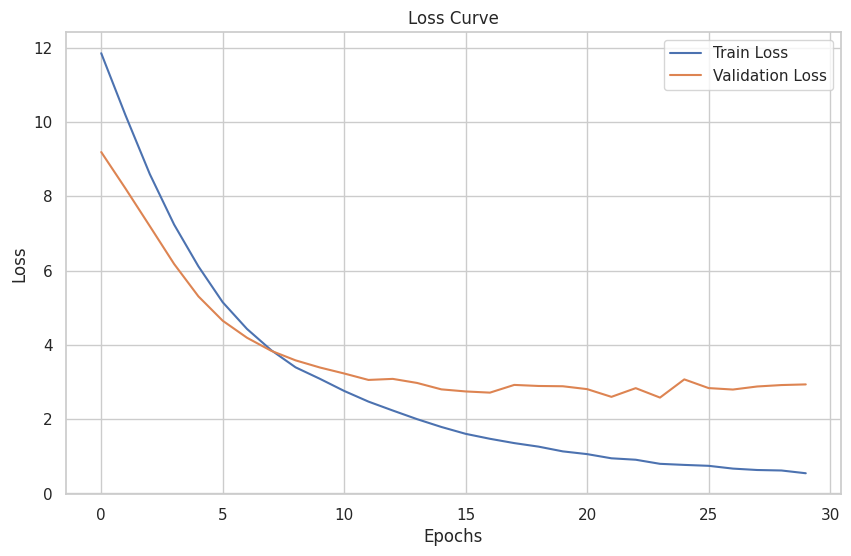

In [38]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**F1 Score Curve Visualization:**
Similar to the loss curve, this section visualizes the F1 micro and F1 macro scores during training and validation. These plots provide insight into the model's classification performance across different classes, allowing for a better understanding of how well the model is performing overall.

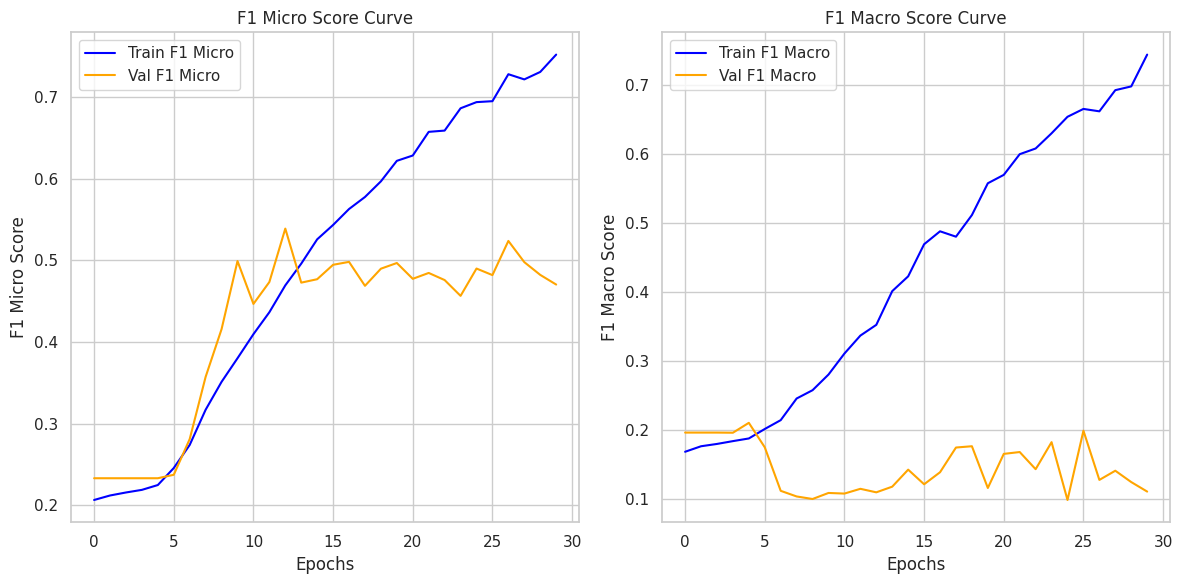

In [39]:
# Create a figure for the F1 Micro and F1 Macro plots
plt.figure(figsize=(12, 6))

# Plot F1 Micro score over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['f1_micro'], label='Train F1 Micro', color='blue')
plt.plot(history.history['val_f1_micro'], label='Val F1 Micro', color='orange')
plt.title('F1 Micro Score Curve')
plt.xlabel('Epochs')
plt.ylabel('F1 Micro Score')
plt.legend()

# Plot F1 Macro score over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_macro'], label='Train F1 Macro', color='blue')
plt.plot(history.history['val_f1_macro'], label='Val F1 Macro', color='orange')
plt.title('F1 Macro Score Curve')
plt.xlabel('Epochs')
plt.ylabel('F1 Macro Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# B. Enhancement Task - Multi-Label Sequence Tagging

In this enhancement task, the objective is to develop a model that utilizes the BERT architecture for the purpose of multi-label sequence tagging. This task focuses on identifying specific spans of text that are associated with multiple techniques, allowing for a more nuanced understanding of the content. The process involves several key steps, including text tokenization, the creation of custom labeling schemes, and the implementation of a specialized deep learning architecture designed to handle the complexities of multi-label classification. Through the integration of advanced techniques in natural language processing, this approach aims to enhance the model's capability in effectively detecting and categorizing diverse techniques within text data.

## 1. Loading Data
The loading data section is crucial for preparing the necessary datasets for training, validation, and testing the multi-label sequence tagging model. This process involves specifying the directories and filenames for the training, validation, and test datasets, utilizing a function to load these datasets into DataFrames for easy manipulation and access. Additionally, it includes reading a list of possible techniques from a text file, which will serve as labels for the tagging task. This systematic loading of data ensures that all components required for effective model training and evaluation are in place.

### 1.1 Loading Training Data

In [40]:
train_folder_name = f'{directory}EnhancementTask'
train_filename = 'training_set_task2.txt'
train_df = load_data_from_file(train_folder_name, train_filename)

### 1.2 Loading Validation Data

In [41]:
dev_folder_name = f'{directory}EnhancementTask'
dev_filename = 'dev_set_task2.txt'
dev_df = load_data_from_file(dev_folder_name, dev_filename)

### 1.3 Loading Testing Data

In [42]:
test_folder_name = f'{directory}EnhancementTask'
test_filename = 'test_set_task2.txt'
test_df = load_data_from_file(test_folder_name, test_filename)

### 1.4 Load the possible techniques

In [43]:
# Define the file path
file_path = f'{directory}EnhancementTask/techniques_list_task2.txt'

try:
    # Open and read the file, filtering out empty lines
    with open(file_path, 'r') as file:
        techniques_list = [line.strip() for line in file if line.strip()]

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path and try again.")

## 2. EDA

### 2.1 Data Sample
This section displays the first few rows of the training, validation, and testing datasets to provide an overview of the data structure and contents. It also enumerates the available techniques, revealing a total number of techniques for tagging.

In [44]:
train_df.head()

,id,text,labels
0,128,THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n,"[{'start': 0, 'end': 41, 'technique': 'Black-a..."
1,189,This is not an accident!,[]
2,96,SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...,"[{'end': 83, 'start': 47, 'technique': 'Slogan..."
3,154,PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...,"[{'end': 8, 'start': 0, 'technique': 'Loaded L..."
4,15,WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n,[]


In [45]:
dev_df.head()

,id,text,labels
0,62_batch_2,"*President* Biden?\n\nPlease, no.\n",[]
1,111_batch_2,"JOE VERSUS THE VOLCANIC KREMLIN DON\n\n""WILL ...","[{'start': 48, 'end': 55, 'technique': 'Loaded..."
2,167_batch_2,ANTI-VAXXERS BE LIKE... \n\nHANG ON A SEC - JU...,[]
3,93_batch_2,VIRUS BINGO\nFREE 32 SPACE\n,[]
4,153_batch_2,Never thought l'd die fighting IRRESPONSIBLY R...,"[{'start': 18, 'end': 30, 'technique': 'Exagge..."


In [46]:
test_df.head()

,id,text,labels
0,705_batch_2,The Democrats New America\n,"[{'start': 0, 'end': 25, 'technique': 'Name ca..."
1,706_batch_2,WE ARE AT WAR!\n\nThere is a complex assault o...,"[{'start': 0, 'end': 149, 'technique': 'Appeal..."
2,710_batch_2,KILLED HIMSELF IN PRISON\n\nWON AN HONEST ELEC...,"[{'start': 0, 'end': 24, 'technique': 'Loaded ..."
3,713_batch_2,I will never concede!\n\nNO WAY IN HELL BIDEN ...,"[{'start': 23, 'end': 37, 'technique': 'Loaded..."
4,715_batch_2,TRYING TO FIGURE OUT HOW BIDEN WON A RECORD LO...,"[{'start': 0, 'end': 146, 'technique': 'Doubt'..."


In [47]:
for i , technique in enumerate(techniques_list):
    print(f"{i+1} : {technique}")

num_labels = len(techniques_list)
print(f"Total number of technique: {num_labels}")

1 : Appeal to authority
2 : Appeal to fear/prejudice
3 : Black-and-white Fallacy/Dictatorship
4 : Causal Oversimplification
5 : Doubt
6 : Exaggeration/Minimisation
7 : Flag-waving
8 : Glittering generalities (Virtue)
9 : Loaded Language
10 : Misrepresentation of Someone's Position (Straw Man)
11 : Name calling/Labeling
12 : Obfuscation, Intentional vagueness, Confusion
13 : Presenting Irrelevant Data (Red Herring)
14 : Reductio ad hitlerum
15 : Repetition
16 : Slogans
17 : Smears
18 : Thought-terminating cliché
19 : Whataboutism
20 : Bandwagon
Total number of technique: 20


### 2.2 Rows with Missing labels
This part analyzes the datasets for rows with missing labels. It counts and reports the number of rows with empty labels in the training, validation, and testing datasets, highlighting potential issues that may need addressing before model training.

In [48]:
# For train_df
empty_list_rows_train = train_df[train_df['labels'].apply(lambda x: len(x) == 0)]
print(f"Rows with empty labels in train: {empty_list_rows_train['labels'].count()}")

# For dev_df
empty_list_rows_dev = dev_df[dev_df['labels'].apply(lambda x: len(x) == 0)]
print(f"Rows with empty labels in dev: {empty_list_rows_dev['labels'].count()}")

# For test_df
empty_list_rows_test = test_df[test_df['labels'].apply(lambda x: len(x) == 0)]
print(f"Rows with empty labels in test: {empty_list_rows_test['labels'].count()}")


Rows with empty labels in train: 143
Rows with empty labels in dev: 15
Rows with empty labels in test: 41


## 3. Dataset

### Loading the Tokenizer and Initializing MultiLabelBinarizer

This section starts by loading the BERT tokenizer (`bert-base-uncased`) to process input text for the BERT model. Next, the `MultiLabelBinarizer` is initialized and fitted with the list of techniques (`techniques_list`) to enable the conversion of multi-label outputs into binary format.

### Creating the TensorFlow Dataset

The `create_tf_dataset` function is defined to convert the input DataFrame into a TensorFlow dataset:

1. **Initialization:** Three lists are created to store `input_ids`, `attention_masks`, and `token_labels`.
2. **Data Processing:** The function iterates through the DataFrame, tokenizes the text, and creates attention masks. For each label, it uses offset mapping to assign multi-hot encoded labels to the corresponding tokens in the tokenized text.
3. **Conversion to Tensors:** The lists are converted into TensorFlow tensors.
4. **Dataset Creation:** A TensorFlow dataset is created from the input IDs and attention masks, with optional shuffling and batching for efficient training.

Finally, the function is called to create datasets for training (`train_dataset`), validation (`dev_dataset`), and testing (`test_dataset`).


In [49]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=techniques_list)
mlb.fit([techniques_list])  # Fit on all possible classes

# Create the function with MultiLabelBinarizer
def create_tf_dataset(df, max_length=512, batch_size=32, shuffle=True):
    input_ids = []
    attention_masks = []
    token_labels = []

    # Tokenize and align labels
    for _, row in df.iterrows():
        text = row['text']
        labels = row['labels']

        # Tokenize text and get offset mapping
        encoding = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_offsets_mapping=True)

        # Initialize a token-level label list (multi-label, one per token)
        token_label = np.zeros((max_length, len(techniques_list)))

        # Process each label
        for label in labels:
            start, end = label['start'], label['end']
            technique = label['technique']

            # Convert technique to a multi-hot encoded vector
            one_hot = mlb.transform([[technique]])[0]  # Transform technique to one-hot

            # Assign one-hot encoding to tokens in the span
            for idx, (token_start, token_end) in enumerate(encoding['offset_mapping']):
                if token_start >= start and token_end <= end:
                    token_label[idx] = one_hot  # Multi-hot encoding for the specific token

        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        token_labels.append(token_label)

    # Convert lists to tensors
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    labels = tf.convert_to_tensor(token_labels)

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels))

    # Shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(input_ids))

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    return dataset

train_dataset = create_tf_dataset(train_df)
dev_dataset = create_tf_dataset(dev_df)
test_dataset = create_tf_dataset(test_df)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 4. Multi-label Sequence Tagging Model
This section focuses on building the architecture of the multi-label sequence tagging model using BERT transformer model known for its ability to understand context in language.

### 4.1 Architecture

The F1 score is a crucial metric for evaluating multi-label classification models, as it balances precision and recall. Here, the F1Score object is initialized without averaging, which allows the model to compute the F1 score for each individual label separately. This is especially important in scenarios where some labels may have more significance or frequency than others.

The custom_f1_score function is designed to reshape the true and predicted labels into a format suitable for F1 score calculation. By reshaping both y_true and y_pred into a two-dimensional tensor with dimensions [batch_size * seq_len, num_labels], it ensures that the F1 score can be computed for each label without aggregation. This granularity allows for a more detailed evaluation of the model's performance across all labels.

In [50]:
# Pre-create the F1 score metric without averaging
f1_metric = F1Score(average=None, threshold=0.25)

def custom_f1_score(y_true, y_pred):
    # Reshape the true and predicted labels to (batch_size * seq_len, num_labels)
    y_true_reshaped = tf.reshape(y_true, [-1, num_labels])
    y_pred_reshaped = tf.reshape(y_pred, [-1, num_labels])
    # Calculate F1 score without aggregation
    return f1_metric(y_true_reshaped, y_pred_reshaped)

The BertForSpanClassification class defines the architecture of the model, inheriting from the Keras Model class. Key components include:

BERT Layer: The model initializes a BERT model using TFBertModel from the Hugging Face Transformers library. This allows the model to leverage pre-trained language representations. By setting certain layers of BERT to be trainable based on the trainable_layers parameter, the model can fine-tune these layers during training, adapting them to the specific task at hand.

Dense Layer: A dense layer with ReLU activation processes the BERT outputs. This layer serves to transform the high-dimensional embeddings produced by BERT into a space that the classifier can work with effectively.

Dropout Layer: A dropout layer is included to prevent overfitting during training. By randomly setting a fraction of input units to zero during training, it helps the model generalize better on unseen data.

Classifier Layer: The final classification layer uses a sigmoid activation function to output probabilities for each label, indicating the likelihood that each technique is present in the corresponding token sequence.

The call method defines the forward pass of the model. It extracts the input_ids and attention_mask from the input dictionary, feeds them into the BERT model, and subsequently processes the output through the dense, dropout, and classifier layers to produce logits.

In [51]:
class BertForSpanClassification(Model):
    def __init__(self, num_labels, dense_units, dropout_rate, trainable_layers):
        super(BertForSpanClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

        # Unfreeze the last few layers of BERT based on hyperparameter
        for layer in self.bert.layers[-trainable_layers:]:
            layer.trainable = True

        self.dense = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01))
        self.dropout = Dropout(dropout_rate)
        self.classifier = Dense(num_labels, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))

    def call(self, inputs, training=False):
        # Extract input_ids and attention_mask from inputs dict
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # Forward pass through BERT model
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask, training=training)
        sequence_output = bert_outputs.last_hidden_state

        dense_output = self.dense(sequence_output)

        # Apply dropout
        dropout_output = self.dropout(dense_output, training=training)

        # Classification layer
        logits = self.classifier(dropout_output)
        return logits

### 4.2 Hyper-Parameter Tuning
The hyperparameter tuning section is crucial for optimizing model performance by finding the best set of hyperparameters:

The model_builder function defines the hyperparameters to be tuned, including:
- Dense Units: The number of units in the dense layer, tuned between 128 and 512.
- Dropout Rate: The rate of dropout, tuned between 0.2 and 0.5 to mitigate overfitting.
- Learning Rate: The learning rate for the optimizer, with options including 1e-5, 3e-5, and 5e-5.
- Trainable Layers: The number of BERT layers to unfreeze during training, allowing for fine-tuning of the model.

An instance of BertForSpanClassification is created with the specified hyperparameters, and the model is compiled using the AdamW optimizer, focal loss to address class imbalance, and metrics for precision, recall, and the custom F1 score.

In [52]:
def model_builder(hp):
    # Define hyperparameters to tune
    dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 3e-5])
    trainable_layers = hp.Int('trainable_layers', min_value=1, max_value=10, step=5)

    # Create an instance of the model
    model = BertForSpanClassification(
        num_labels=num_labels,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        trainable_layers=trainable_layers
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay = 1e-3),
        loss=FocalLoss(alpha=0.5, gamma=3),
        metrics=['precision', 'recall', custom_f1_score]
    )

    return model


A Keras Tuner is initialized using a random search strategy. The tuner aims to maximize the validation F1 score over a specified number of trials, effectively searching for the best hyperparameters.

The tuner performs a search across the training dataset, evaluating the model's performance on the validation dataset for a defined number of epochs. This process is vital for identifying the optimal configuration of hyperparameters that yield the best model performance.


In [53]:
# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    kt.Objective("val_custom_f1_score", direction="max"),
    max_trials=5,
    executions_per_trial=1,
    directory=f'{directory}parameter_tuning',
    project_name='bert_span_classification'
)

# Search for the best hyperparameters
tuner.search(
    train_dataset,  # Pass your training dataset here
    validation_data=dev_dataset,  # Pass your validation dataset here
    epochs=3,
)


Reloading Tuner from /content/drive/My Drive/DL_Assign_2/parameter_tuning/bert_span_classification/tuner0.json


Best Hyperparameter Retrieval: After the search, the best hyperparameters are retrieved and printed, providing insights into the optimal settings for the model.

In [54]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best trainable layers: {best_hps.get('trainable_layers')}")


Best dense units: 128
Best dropout rate: 0.4
Best learning rate: 1e-05
Best trainable layers: 6


Early Stopping: This monitors the validation loss, halting training if it fails to improve for a defined number of epochs, thereby preventing overfitting.

Learning Rate Scheduler: It adjusts the learning rate based on validation loss, allowing for fine-tuning of the training process by reducing the learning rate when improvements stall.

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1)

The model is trained using the best hyperparameters identified by the tuner. The training history, including loss and metrics, is recorded for subsequent analysis.

In [56]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - custom_f1_score: 0.0403 - loss: 4.2058 - precision: 0.0178 - recall: 0.4237 - val_custom_f1_score: 0.0389 - val_loss: 3.8506 - val_precision: 0.0184 - val_recall: 0.3988 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - custom_f1_score: 0.0390 - loss: 4.0773 - precision: 0.0177 - recall: 0.4254 - val_custom_f1_score: 0.0391 - val_loss: 3.7538 - val_precision: 0.0187 - val_recall: 0.3854 - learning_rate: 1.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - custom_f1_score: 0.0392 - loss: 3.9859 - precision: 0.0174 - recall: 0.3928 - val_custom_f1_score: 0.0392 - val_loss: 3.6668 - val_precision: 0.0189 - val_recall: 0.3715 - learning_rate: 1.0000e-05
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - custom_f1_score: 0.0394 - loss: 3.8872 - precision: 0.0200 - recall: 0.4193 - val_custom_f1_score: 0.0392 - val_loss: 3.5887 - val_precision: 0.0192 - val_recall: 0.3593 - learning_rate: 1.0000e-05

### 5.3 Evaluation
The model is evaluated on the test dataset to assess its performance metrics, including precision, recall, and F1 score. The results are printed to provide a clear picture of the model's effectiveness in identifying spans of text associated with various techniques.

In [57]:
test_results = best_model.evaluate(test_dataset)
print(f"Test Precision: {test_results[1]}")
print(f"Test Recall: {test_results[2]}")
print(f"Test F1Score: {test_results[3]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - custom_f1_score: 0.0394 - loss: 3.2450 - precision: 0.0230 - recall: 0.2704
Test Precision: 0.021838076412677765
Test Recall: 0.26555585861206055
Test F1Score: 0.03940962627530098


**Plotting Training Curves**

This function visualizes the training and validation loss, precision, recall, and F1 score over epochs. The plots provide insights into the model's learning behavior, helping to identify potential issues such as overfitting or underfitting.

The function is called after training the model using the recorded history object to generate informative plots.

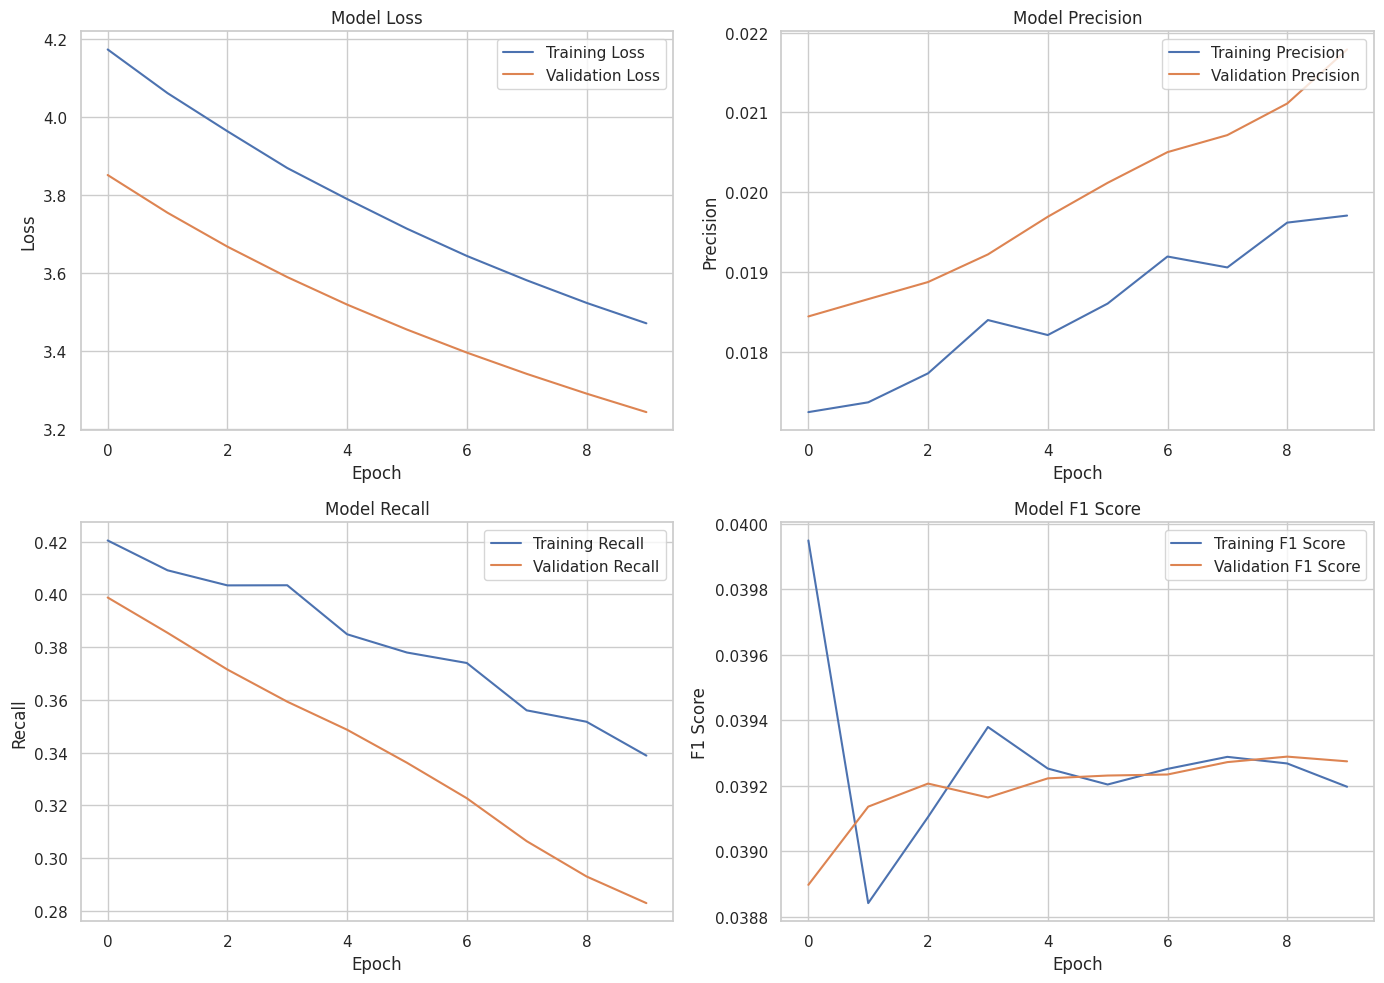

In [58]:
def plot_training_curves(history):
    # Plot training & validation loss values
    plt.figure(figsize=(14, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Precision
    if 'precision' in history.history and 'val_precision' in history.history:
        plt.subplot(2, 2, 2)
        plt.plot(history.history['precision'], label='Training Precision')
        plt.plot(history.history['val_precision'], label='Validation Precision')
        plt.title('Model Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend(loc='upper right')

    # Recall
    if 'recall' in history.history and 'val_recall' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['recall'], label='Training Recall')
        plt.plot(history.history['val_recall'], label='Validation Recall')
        plt.title('Model Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend(loc='upper right')

    # F1 Score
    if 'custom_f1_score' in history.history and 'val_custom_f1_score' in history.history:
        plt.subplot(2, 2, 4)
        plt.plot(history.history['custom_f1_score'], label='Training F1 Score')
        plt.plot(history.history['val_custom_f1_score'], label='Validation F1 Score')
        plt.title('Model F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call this function after training the model with the history object
plot_training_curves(history)


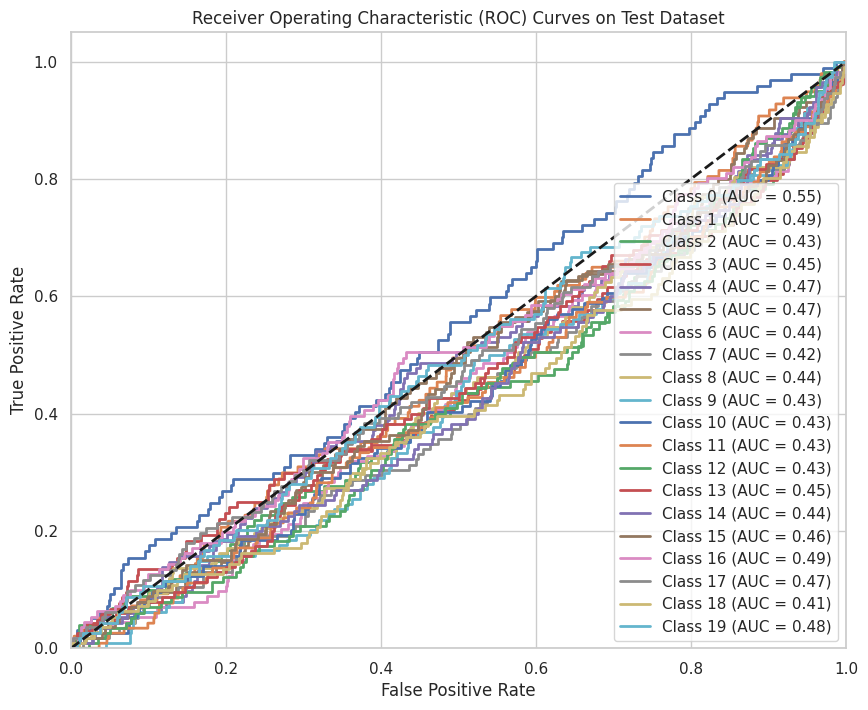

In [59]:
def plot_roc_curves(model, test_dataset, num_labels):
    plt.figure(figsize=(10, 8))

    # Iterate over each label
    for i in range(num_labels):
        # Collect true labels and predictions for the i-th label
        true_labels = []
        predictions = []

        for batch in test_dataset:
            inputs, targets = batch
            true_labels.extend(targets.numpy()[:, i])
            preds = model.predict(inputs, verbose=0)
            predictions.extend(preds[:, i])

        # Convert to numpy arrays and ensure they're 1D
        true_labels = np.array(true_labels).ravel()
        predictions = np.array(predictions).ravel()

        # Compute ROC curve and AUC for the current label
        fpr, tpr, _ = roc_curve(true_labels, predictions, pos_label=1)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for the i-th label
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves on Test Dataset')
    plt.legend(loc='lower right')
    plt.show()

# Call this function with the trained model and the test dataset
plot_roc_curves(best_model, test_dataset, num_labels=num_labels)
